In [60]:
import scipy
from scipy import sparse
import numpy as np 
import sklearn 
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics

import matplotlib.pyplot as plt

import sys
import pickle

## Get pl_queries from db

In [45]:
# get data from SQL 
import pymysql
import configparser

queries={}

# print cursor function
def pc(cursor):
	for x in cursor:
		print(x)

# reads the config file
config = configparser.ConfigParser()
config.read("config.ini")

conn = pymysql.connect(
	host = config.get("Database", "mysql_ip"),
	user = config.get("Database", "mysql_user"),
	passwd = config.get("Database", "mysql_pw"))

mycursor = conn.cursor()

mycursor.execute("Use pl_queries")
mycursor.execute("SELECT * FROM Queries")
# conn.commit()

1418

In [48]:
# 0: ???
# 1: qId
# 2: ???
# 3: query 

for tup in mycursor:
    queries[tup[1]] = tup[3]


# Clustering 

In [4]:
NUM_CLUSTERS = 6

file = "FA19QueryEmbeddings.pickle"
emb=pickle.load(open(file, "rb" ))

In [7]:
data=[]
qids=[]

for key in emb:
    qids.append(key)
    data.append(emb[key])

## Kmeans 

In [11]:
km = KMeans(n_clusters=NUM_CLUSTERS)
km.fit(data)

clusters = km.labels_.tolist()
clusters = np.asarray(clusters)

In [17]:
# testing bincount 
counter={}
for i in clusters:
    if i in counter: 
        counter[i]+=1
    else:
        counter[i] = 1
counter

{2: 93, 0: 75, 4: 2, 1: 9, 3: 22, 5: 11}

<BarContainer object of 6 artists>

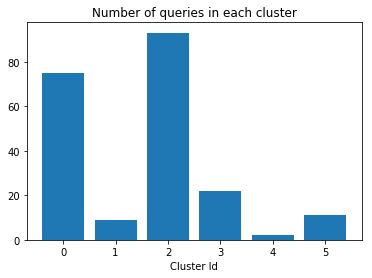

In [59]:
# bincount counts the number of occurences of each number in the array
# i.e., bincount[0] is the # of times 0 occurs 
#       bincount[1] is the # of times 1 occurs 

plt.title("Number of queries in each cluster")
plt.xlabel("Cluster Id")
plt.bar(np.arange(NUM_CLUSTERS),np.bincount(clusters))

### View KMeans results:
- Change "i" to the cluster number 
- All the queries belonging to that cluster will be printed

In [56]:
for idx, i in enumerate(clusters):
    if i==5:
        print(queries[qids[idx]])
        print("\n")

SELECT DISTINCT s.FirstName, s.LastName 
FROM Students s, (SELECT * FROM Enrollments NATURAL JOIN Courses) as d
WHERE s.NetId = d.NetId AND s.Department != d.Department;



SELECT DISTINCT FirstName, LastName
FROM 
(SELECT * 
 FROM Enrollments NATURAL JOIN Courses) as temp JOIN Students
 ON Students.NetId = temp.NetId
WHERE temp.Department != Students.Department


SELECT FirstName, LastName
FROM Students
WHERE (SELECT COUNT(CRN) FROM Courses WHERE Courses.Department<>Students.Department AND CRN IN (SELECT CRN FROM Enrollments WHERE Enrollments.NetId=Students.NetId))


SELECT DISTINCT FirstName, LastName
FROM Students, (SELECT NetId, Department FROM Enrollments INNER JOIN Courses ON Enrollments.CRN = Courses.CRN) AS DepsOfStudents
WHERE Students.NetId = DepsOfStudents.NetID AND Students.Department <> DepsOfStudents.Department;


Select Distinct FirstName, LastName
From Students,
    (SELECT NetId, Department
     From   Enrollments, (SELECT CRN, Department
                          FROM

## Mean shift clustering 

This is useful if we don't know the number of clusters that a dataset should have (i.e., we have unlabeled data). 
Mean shift clustering will automatically choose a number of clusters

In [71]:
from sklearn.cluster import MeanShift
clustering = MeanShift().fit(data)

In [72]:
clustering.labels_

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 0, 0, 2, 2, 1, 0, 1, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1])

<BarContainer object of 6 artists>

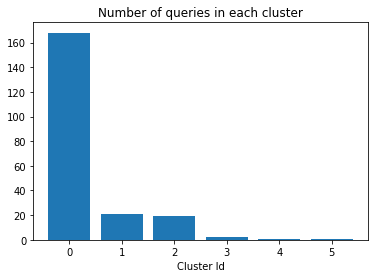

In [73]:
plt.title("Number of queries in each cluster")
plt.xlabel("Cluster Id")
plt.bar(np.arange(NUM_CLUSTERS),np.bincount(clustering.labels_))

## Agglomerative Clustering 

Hierarchical approach. Also good when we don't have a set # of clusters. Aggolmerative means each sample starts in its own cluster, and recursively merges with neighbors depending on a distance/linkage method. 

Types of linkages that we can experiment with (stolen from sklearn): 
- *Ward* minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- *Maximum* or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- *Average* linkage minimizes the average of the distances between all observations of pairs of clusters.
- *Single* linkage minimizes the distance between the closest observations of pairs of clusters.

In [85]:
from sklearn.cluster import AgglomerativeClustering

# FIX: CURRENT VERSION OF SKLEARN DOESNT ALLOW FOR NONE CLUSTERS 
# because distance_threshold isn't an attribute...???
clustering = AgglomerativeClustering(n_clusters=NUM_CLUSTERS, linkage="ward").fit(data)


SyntaxError: positional argument follows keyword argument (<ipython-input-85-1dd5595ded70>, line 4)

<BarContainer object of 6 artists>

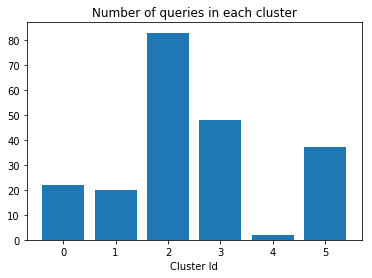

In [83]:
plt.title("Number of queries in each cluster")
plt.xlabel("Cluster Id")
plt.bar(np.arange(NUM_CLUSTERS),np.bincount(clustering.labels_))

In [ ]:
## old code for spectral clustering and ari index if we have labels 

sp = SpectralClustering(n_clusters=NUM_CLUSTERS,
        assign_labels="discretize",
        random_state=0)
sp.fit(data)


ari = metrics.adjusted_rand_score(labels, clusters) 
print("ARI index: " + str(ari))
print("\n\n")

# labels = zip(readme_docs, clusters)
# np.save("pickles/"+pickle_label+"_labels", labels, allow_pickle=True, fix_imports=True)